In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ruptures as rpt

Import some jobs

In [105]:
import os, random
job_files = []
dataset_path = "C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation"
for root, dirs, files in os.walk(dataset_path):
    for csv_file in files:
        if csv_file.endswith(".csv"):
            job_files.append(os.path.join(root, csv_file))
        
# csv_file = os.path.join("C:\\Users\\a770398\IO-SEA\io-sea-3.4-analytics\\dataset_generation\\dataset_generation\\dataset_oth_db\\job_1272.csv")

csv_file = random.choice(job_files)
print(csv_file)



C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_sop_db\job_3564.csv


Basic plot

C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_genji_IOI_BD260919\job_465155.csv
(107, 5)


<AxesSubplot:>

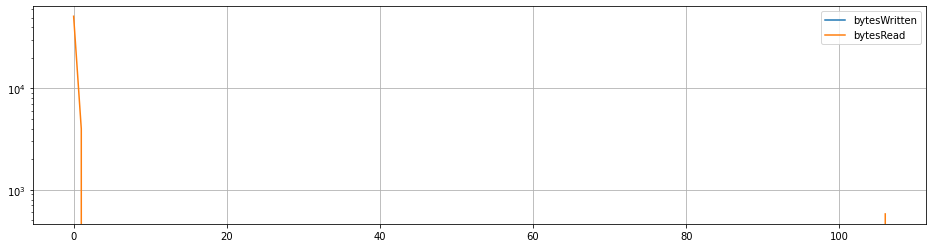

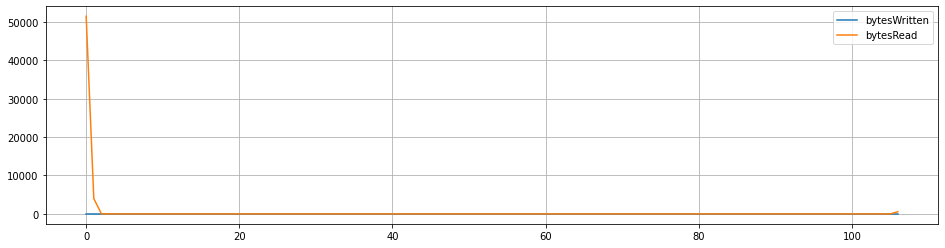

In [229]:
import os, random
job_files = []
dataset_path = "C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation\\dataset_gysela"
for root, dirs, files in os.walk(dataset_path):
    for csv_file in files:
        if csv_file.endswith(".csv"):
            job_files.append(os.path.join(root, csv_file))
        
# csv_file = os.path.join("C:\\Users\\a770398\IO-SEA\io-sea-3.4-analytics\\dataset_generation\\dataset_generation\\dataset_oth_db\\job_1272.csv")

csv_file = random.choice(job_files)
print(csv_file)
df = pd.read_csv(csv_file, index_col=0)
print(df.shape)
df.plot(y=["bytesWritten", "bytesRead"], figsize=(16,4), sharex=True, grid=True, use_index=True, logy=True)
df.plot(y=["bytesWritten", "bytesRead"], figsize=(16,4), sharex=True, grid=True, use_index=True)


retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_gysela\job_109567.csv
(3242, 5)


<AxesSubplot:>

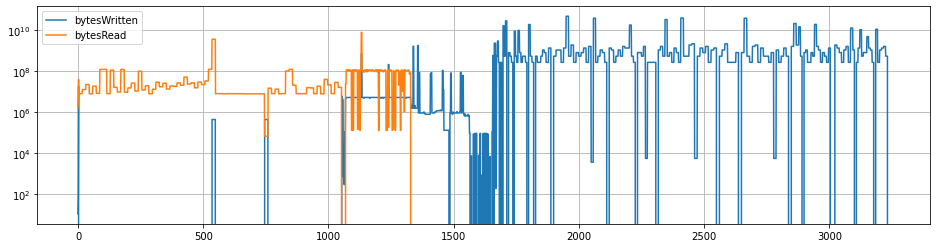

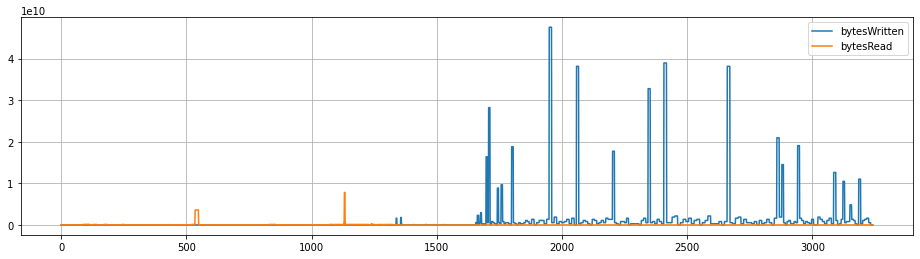

In [246]:
from utils import get_df_by_job_id
df = get_df_by_job_id(job_id=109567)
print(df.shape)
df.plot(y=["bytesWritten", "bytesRead"], figsize=(16,4), sharex=True, grid=True, use_index=True, logy=True)
df.plot(y=["bytesWritten", "bytesRead"], figsize=(16,4), sharex=True, grid=True, use_index=True)


Now we apply some algos on the bidimensional signal (y1=["bytesRead"], y2=["bytesWritten"]

In [ ]:
signal = df[["bytesRead"]].to_numpy()

dyn_result = rpt.Dynp(model="rbf").fit(signal).predict(n_bkps=6)
pelt_result = rpt.Pelt(model="rbf", min_size=3).fit(signal).predict(pen=0.1)
kcpd_result = rpt.KernelCPD(kernel="rbf").fit(signal).predict(pen=0.1) # a c implementation of dyn/pelt
binseg_result = rpt.Binseg(model="l2").fit(signal).predict(pen=0.1)
botup_result = rpt.BottomUp(model="l2").fit(signal).predict(pen=0.1)
wind_result = rpt.Window(model="l2", width=10).fit(signal).predict(pen=0.1)

rpt.display(signal, dyn_result)
rpt.display(signal, pelt_result)
rpt.display(signal, kcpd_result)
rpt.display(signal, binseg_result)
rpt.display(signal, botup_result)
rpt.display(signal, wind_result)

df[["bytesRead"]].cumsum().plot()
df[["bytesWritten"]].cumsum().plot()

Some biblio:
- https://arxiv.org/abs/2003.06222
- https://arxiv.org/pdf/1801.00718.pdf
- https://github.com/alan-turing-institute/TCPDBench
- https://www.youtube.com/watch?v=Sb89wJaCp7o&ab_channel=VideoLecturesChannel
- https://notebook.community/hildensia/bayesian_changepoint_detection/Example%20Code
- https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/
- https://schuetzgroup.github.io/sdt-python/changepoint.html
- https://centre-borelli.github.io/ruptures-docs/
- https://paperswithcode.com/task/change-point-detection
- https://github.com/YKatser/CPDE
- https://arxiv.org/pdf/2204.07403v1.pdf
- https://github.com/cruiseresearchgroup/TSCP2

Estimating cost value

In [ ]:
def choose_random_job(dataset_path = "C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation"):
    job_files = []    
    for root, dirs, files in os.walk(dataset_path):
        for csv_file in files:
            if csv_file.endswith(".csv"):
                job_files.append(os.path.join(root, csv_file))
    return random.choice(job_files)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import ruptures as rpt
import os, random
csv_file = choose_random_job()
df = pd.read_csv(csv_file, index_col=0)
df.plot(x="timestamp", figsize=(16,4), sharex=True, grid=True, subplots=True, layout=(1, 4))

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

signal = df[["bytesWritten"]].to_numpy()
for cost in [rpt.costs.CostL1(), rpt.costs.CostL2(), rpt.costs.CostNormal(), rpt.costs.CostLinear()]:
             #rpt.costs.CostAR(order=10), rpt.costs.CostMl(metric=np.eye(1)), rpt.costs.CostRank()]:
    result = rpt.Pelt(custom_cost=cost).fit(signal).predict(pen=1000)
#pelt_result = rpt.Pelt(model="rbf", min_size=3).fit(signal).predict(pen=0.1)
#print(cost.fit(signal).error(0, len(signal)))
    print("===================")
    rpt.display(signal, result)
    print(result)
    print(cost.sum_of_costs(result))
    
    # reconstruction loop:
    compute = [0]
    write = [0]
    bandwidth = [0]
    closing_point = 0
    for i_brkpt, brkpt in enumerate(result[:-1]):
        if (i_brkpt % 2) == 0: # starting point
            starting_point = brkpt
            compute.append(compute[-1] + (starting_point - closing_point))
        if (i_brkpt %2) != 0: # closing point
            closing_point = brkpt
            phase_volume = integrate.trapz(y=signal[starting_point: closing_point].flatten(), dx=5)
            write.append(phase_volume)
            
    print(f"compute= {compute} -- write = {write}")
        
            
            

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ruptures as rpt
import os, random, time

# choose a job
def list_jobs(dataset_path = "C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation"):
    job_files = []
    job_ids = []
    dataset = []
    for root, dirs, files in os.walk(dataset_path):
        for csv_file in files:
            if csv_file.endswith(".csv"):
                job_files.append(os.path.join(root, csv_file))
                job_ids.append(csv_file.split("_")[-1].split(".csv")[0])
                dataset.append(os.path.split(root)[-1])
    return job_files, job_ids, dataset
job_files, job_ids, datasets = list_jobs()


Benchmarking offline algos

In [ ]:
df = pd.DataFrame(columns=["dataset", "jobid", "timeserie", "signal_length", "n_brkpts",
                           "algo_name", "cost_function", "loss", "penalty", "computation_time"])

job_files, job_ids, datasets = list_jobs()
for job_file, job_id, dataset in zip(job_files[0:2], job_ids[0:2], datasets[0:2]):
    df_signal = pd.read_csv(job_file, index_col=0)
    for ts in ["bytesWritten", "bytesRead"]:
        signal = df_signal[[ts]].to_numpy()
        signal_dim = signal.shape[1]

        # define costs
        costs = [rpt.costs.CostL1(), rpt.costs.CostL2(), rpt.costs.CostNormal(), rpt.costs.CostLinear(),
                rpt.costs.CostCLinear(), rpt.costs.CostAR(order=3), rpt.costs.CostMl(metric=np.eye(signal_dim)), rpt.costs.CostRank()]
        costs_names = ["L1", "L2", "Gauss", "Linear", "Clinear", "AR", "Mala", "Rank"]

        # algos = [rpt.Pelt(custom_cost=cost, min_size=2), rpt.Binseg(custom_cost=cost),
        #          rpt.BottomUp(custom_cost=cost), rpt.Window(custom_cost=cost, width=10)]

        algos = [rpt.Pelt, rpt.Binseg, rpt.BottomUp, rpt.Window]

        algos_names = ["Pelt", "Binseg", "Botup", "Wind"]

        penalties = np.logspace(-3, 3, num=6).tolist()
# ["dataset", "jobid", "timeserie", "signal_length", "n_brkpts",
#                            "algo_name", "cost_function", "loss", "penalty", "computation_time"]
        for algo, algo_name in zip(algos[0:2], algos_names[0:2]):
            for cost, costs_name in zip(costs[0:2], costs_names[0:2]):
                for pen in penalties[0:2]:
                    try:
                        start_time = time.time()
                        result = algo(custom_cost=cost, min_size=2).fit_predict(signal, pen)
                        duration = time.time() - start_time
                        n_brkpts = len(result) - 1
                        loss = cost.sum_of_costs(result)
                        df = df.append({"dataset": dataset,
                                        "jobid": job_id,
                                        "timeserie": ts,
                                        "signal_length": signal.shape[0],
                                        "n_brkpts": n_brkpts,
                                        "algo_name": algo_name,
                                        "cost_function": costs_name,
                                        "loss": loss,
                                        "penalty": pen,
                                        "computation_time": duration,
                                        },
                                    ignore_index=True)
                    except:
                        pass
                
df.to_csv("_".join(algos_names) + "_bench.csv")

In [ ]:
df.head()

Visualize some jobs


In [ ]:
job_files = []
dataset_path = "C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation"
for root, dirs, files in os.walk(dataset_path):
    for csv_file in files:
        if csv_file.endswith(".csv"):
            job_files.append(os.path.join(root, csv_file))
        
# csv_file = os.path.join("C:\\Users\\a770398\IO-SEA\io-sea-3.4-analytics\\dataset_generation\\dataset_generation\\dataset_oth_db\\job_1272.csv")

csv_file = random.choice(job_files)

loss = 4.271078373412319e+18
len(breakpoints) = 138


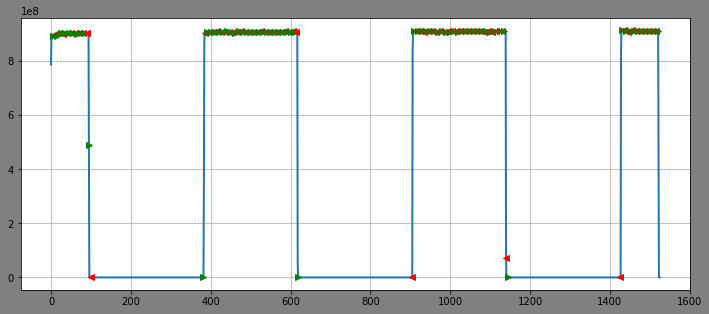

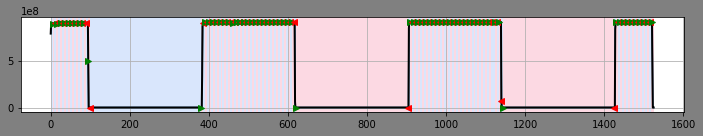

In [337]:
import os, random
import numpy as np
import pandas as pd
import simpy
import os, random
import ruptures as rpt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

def plot_job_phases(x, signal, breakpoints):
    
    x = ((np.array(x) - x[0])/5).tolist()
    plt.rcParams["figure.figsize"] = (12, 5)
    plt.rcParams['figure.facecolor'] = 'gray'
    
    plt.plot(x, signal, lw=2, label="IO")            
    for i_brk, brk in enumerate(breakpoints[:-1]): #avoid last point
        if i_brk % 2 == 0: # opening point
            plt.plot(x[brk], signal[brk], '>g')
        else:
            plt.plot(x[brk], signal[brk], '<r')
    plt.grid(True)
    plt.show()
    
def plot_job_phases2(x, signal, breakpoints):
    signal = np.array(signal)    
    x = ((np.array(x) - x[0])/5).tolist()
    fig, ax = rpt.display(signal, breakpoints)
    ax[0].plot(x, signal, lw=2, label="IO", color='k')      
    
    for i_brk, brk in enumerate(breakpoints[:-1]): #avoid last point
        if i_brk % 2 == 0: # opening point
            ax[0].plot(x[brk], signal[brk], '>g')
        else:
            ax[0].plot(x[brk], signal[brk], '<r')
    plt.grid(True)
    plt.show()



df = pd.read_csv(csv_file, index_col=0)
signal = df[["bytesWritten"]].to_numpy().tolist()
x = df[["timestamp"]].to_numpy().tolist()
# executin algo on signal
# rpt.costs.CostL1(), rpt.costs.CostL2(), rpt.costs.CostNormal(), rpt.costs.CostLinear()
# rpt.costs.CostAR(order=10), rpt.costs.CostMl(metric=np.eye(1)), rpt.costs.CostRank()]:
cost = rpt.costs.CostL2()
breakpoints = rpt.Pelt(custom_cost=cost).fit(df[["bytesWritten"]].to_numpy()).predict(pen=1)
loss = cost.sum_of_costs(breakpoints)
print(f"{loss = }")
print(f"{len(breakpoints) = }")
#pelt_result = rpt.Pelt(model="rbf", min_size=3).fit(signal).predict(pen=0.1)
#print(cost.fit(signal).error(0, len(signal)))

    
plot_job_phases(x, signal, breakpoints)
plot_job_phases2(x, signal, breakpoints)



Visualize from bench file

In [203]:
def get_df_by_job_id(job_id=1391):
    job_files, job_ids, datasets = list_jobs()
    csv_file = job_files[job_ids.index(str(job_id))]
    print(f"retrieving {csv_file}")
    return pd.read_csv(csv_file, index_col=0)


df = get_df_by_job_id()

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_oth_db\job_1391.csv


In [192]:
   

def plot_bench_decomposition(bench_file="Pelt_Binseg_Botup_Wind_bench.csv", idx=0):
        

    bench_df = pd.read_csv(bench_file, index_col=0)

    algos = [rpt.Pelt, rpt.Binseg, rpt.BottomUp, rpt.Window]
    algos_names = ["Pelt", "Binseg", "Botup", "Wind"]
    # define costs
    costs = [rpt.costs.CostL1(), rpt.costs.CostL2(), rpt.costs.CostNormal(), rpt.costs.CostLinear(),
            rpt.costs.CostCLinear(), rpt.costs.CostAR(order=3), rpt.costs.CostMl(metric=np.eye(1)), rpt.costs.CostRank()]
    costs_names = ["L1", "L2", "Gauss", "Linear", "Clinear", "AR", "Mala", "Rank"]

    #df.iloc[idx]["jobid"]
    algo = algos[algos_names.index(bench_df.iloc[idx]["algo_name"])]
    cost = costs[costs_names.index(bench_df.iloc[idx]["cost_function"])]
    penalty = bench_df.iloc[idx]["penalty"]
    timeserie = bench_df.iloc[idx]["timeserie"]

    job_files, job_ids, datasets = list_jobs()
    str_jobid = str(bench_df.iloc[idx]["jobid"])
    print(f"{algo = }")
    print(f"{cost = }")
    csv_file = job_files[job_ids.index(str_jobid)]
    print(f"{csv_file = }")
    df = pd.read_csv(csv_file, index_col=0)

    signal = df[[timeserie]].to_numpy().tolist()
    x = df[["timestamp"]].to_numpy().tolist()
    print(f"length of signal = {len(signal)}")
    breakpoints = algo(custom_cost=cost, min_size=1, jump=1).fit_predict(df[[timeserie]].to_numpy(), pen=penalty)
    loss = cost.sum_of_costs(breakpoints)
    print(f"{penalty = }")
    print(f"{loss = }")
    print(f"number of breakpoints = {len(breakpoints)-1}")
        
    plot_job_phases(x, signal, breakpoints)

algo = <class 'ruptures.detection.binseg.Binseg'>
cost = <ruptures.costs.costl1.CostL1 object at 0x000001A9F5C4D8E0>
csv_file = 'C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation\\dataset_oth_db\\job_1391.csv'
length of signal = 1526
penalty = 100.0
loss = 427064607141.0
number of breakpoints = 56


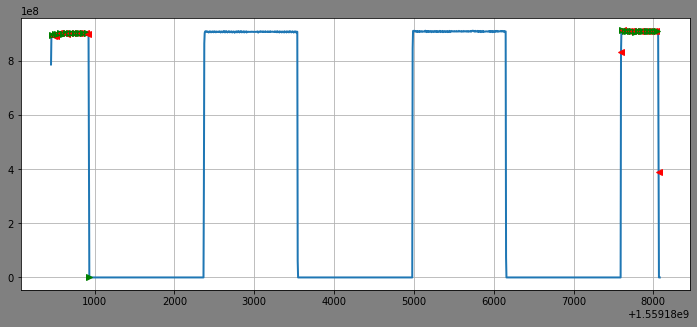

In [158]:
plot_bench_decomposition("simple_bench_oth_db.csv", idx=19)

In [ ]:
df.head()

In [183]:
bench_df = pd.read_csv("simple_bench_oth_db.csv", index_col=0)
l2_df = bench_df[bench_df["cost_function"].isin(["L2"])]
l2_df = l2_df[l2_df["dataset"].isin(["dataset_oth_db"])]
l2_df.head()
l2_df["score"] = l2_df["loss"] / l2_df["n_brkpts"]
l2_df.sort_values(by=["score"], inplace=True)
l2_df.head(n=40)

,dataset,jobid,timeserie,signal_length,n_brkpts,algo_name,cost_function,loss,penalty,computation_time,score
7,dataset_oth_db,1391,bytesWritten,1526,312,Pelt,L2,2.339647e+17,0.001,13.499907,7.498869e+14
8,dataset_oth_db,1391,bytesWritten,1526,312,Pelt,L2,2.339647e+17,0.010,13.469675,7.498869e+14
9,dataset_oth_db,1391,bytesWritten,1526,312,Pelt,L2,2.339647e+17,0.100,13.486572,7.498869e+14
10,dataset_oth_db,1391,bytesWritten,1526,312,Pelt,L2,2.339647e+17,1.000,13.514378,7.498869e+14
11,dataset_oth_db,1391,bytesWritten,1526,312,Pelt,L2,2.339647e+17,10.000,13.507745,7.498869e+14
12,dataset_oth_db,1391,bytesWritten,1526,312,Pelt,L2,2.339647e+17,100.000,13.479510,7.498869e+14
13,dataset_oth_db,1391,bytesWritten,1526,312,Pelt,L2,2.339647e+17,1000.000,13.494992,7.498869e+14
25,dataset_oth_db,1391,bytesWritten,1526,100,Binseg,L2,4.970630e+17,100.000,1.736205,4.970630e+15
24,dataset_oth_db,1391,bytesWritten,1526,10,Binseg,L2,5.042211e+17,10.000,1.150302,5.042211e+16
20,dataset_oth_db,1391,bytesWritten,1526,1,Binseg,L2,2.818804e+20,0.001,0.445304,2.818804e+20


c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\ruptures\costs\costnormal.py:28: UserWarning:

New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).



algo = <class 'ruptures.detection.binseg.Binseg'>
cost = <ruptures.costs.costl2.CostL2 object at 0x000001A9F6202580>
csv_file = 'C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation\\dataset_oth_db\\job_1391.csv'
length of signal = 1526
penalty = 0.015848931924611134
loss = 4.969927705713653e+17
number of breakpoints = 195


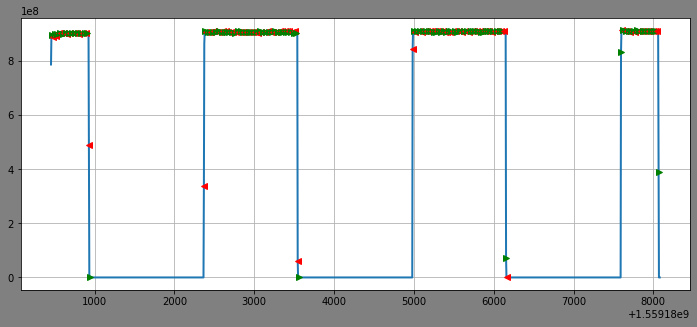

In [184]:
plot_bench_decomposition(idx=24)

Elbow method

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_oth_db\job_1439.csv
len(signal) = 1536
n_bkps_max = 39
True
array_of_n_bkps = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])
costs = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
optimal_n_breakpoints = 39
costs = [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
optimal_cost = nan


c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\scipy\signal\_peak_finding.py:74: RuntimeWarning:

invalid value encountered in greater_equal

c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\scipy\signal\_peak_finding.py:75: RuntimeWarning:

invalid value encountered in greater_equal

c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\scipy\signal\_peak_finding.py:74: RuntimeWarning:

invalid value encountered in less_equal

c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\scipy\signal\_peak_finding.py:75: RuntimeWarning:

invalid value encountered in less_equal

c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\kneed\knee_locator.py:237: RuntimeWarning:

No local maxima found in the difference curve
The line is probably not polynomial, try plotting
the difference curve with plt.plot(knee.x_difference, knee.y_

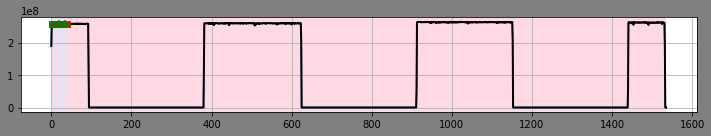

In [340]:
import ruptures as rpt
from kneed import KneeLocator

df = get_df_by_job_id(job_id=1439)
signal = df[["bytesWritten"]].to_numpy()
x = df[["timestamp"]].to_numpy().tolist()
# generate signal
print(f"{len(signal) = }")
algo = rpt.KernelCPD(kernel="rbf", min_size=1).fit(signal)
n_bkps_max = int((np.sqrt(len(signal))))
print(f"{n_bkps_max = }")
# check sanity
print(rpt.utils.sanity_check(len(signal), n_bkps_max, 1, 1))

# segment
_ = algo.predict(n_bkps_max)


array_of_n_bkps = np.arange(1, n_bkps_max + 1)

def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

costs = [np.abs(get_sum_of_cost(algo=algo, n_bkps=n_bkps)) for n_bkps in array_of_n_bkps]
print(f"{array_of_n_bkps = }")
print(f"{costs = }")
elbow = KneeLocator(array_of_n_bkps, costs, S= 1,
                         curve="convex",  direction="decreasing").elbow

optimal_n_breakpoints = elbow if elbow else n_bkps_max

print(f"{optimal_n_breakpoints = }")
print(f"{costs = }")
optimal_breakpoints = algo.predict(n_bkps=optimal_n_breakpoints)
optimal_cost = costs[array_of_n_bkps.tolist().index(optimal_n_breakpoints)]
print(f"{optimal_cost = }")
plot_job_phases2(x, signal, optimal_breakpoints)
#rpt.display(signal, optimal_breakpoints)
#plt.grid(True)
#plt.show()


Using an encapsulated function

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_oth_db\job_1439.csv
optimal_n_breakpoints = 6
optimal_cost = 2.5288484590467517e+17


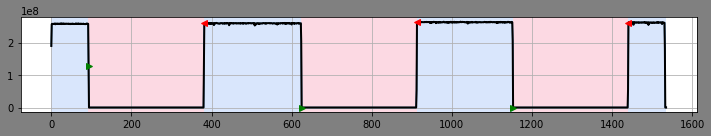

In [348]:
import ruptures as rpt
from kneed import KneeLocator

df = get_df_by_job_id(job_id=1439)
signal = df[["bytesWritten"]].to_numpy()
x = df[["timestamp"]].to_numpy().tolist()

def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

def get_optimal_breakpoints(signal, algo=rpt.KernelCPD, kernel="linear"):
    initialized_algo = algo(kernel=kernel, min_size=1).fit(signal)
    n_bkps_max = int((np.sqrt(len(signal))))
    # segment
    _ = initialized_algo.predict(n_bkps_max)
    array_of_n_bkps = np.arange(1, n_bkps_max + 1)
    costs = [get_sum_of_cost(algo=initialized_algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps]
    elbow = KneeLocator(array_of_n_bkps, costs, S= 1,
                         curve="convex",  direction="decreasing").elbow
    optimal_n_breakpoints = elbow if elbow else n_bkps_max
    optimal_breakpoints = initialized_algo.predict(n_bkps=optimal_n_breakpoints)
    optimal_cost = costs[array_of_n_bkps.tolist().index(optimal_n_breakpoints)]
    
    return optimal_n_breakpoints, optimal_breakpoints, optimal_cost


algo = rpt.KernelCPD
optimal_n_breakpoints, optimal_breakpoints, optimal_cost = get_optimal_breakpoints(signal)





print(f"{optimal_n_breakpoints = }")
print(f"{optimal_cost = }")
plot_job_phases2(x, signal, optimal_breakpoints)
#rpt.display(signal, optimal_breakpoints)
#plt.grid(True)
#plt.show()


csv_file = 'C:\\Users\\a770398\\IO-SEA\\io-sea-3.4-analytics\\dataset_generation\\dataset_generation\\dataset_mat_db\\job_6382.csv'
length of signal = 156
breakpoints = [2, 74, 76, 112, 114, 151, 156]
number of breakpoints = 6


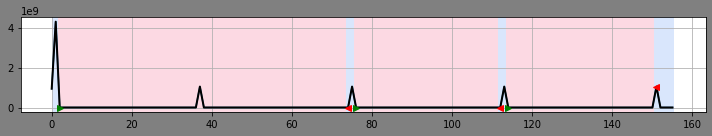

In [360]:
def plot_bench_decomposition_cpd(bench_file="kernel_cpd.csv", idx = 0):
    bench_df = pd.read_csv(bench_file, index_col=0)

    algo = rpt.KernelCPD
    # define costs
    kernels = ["rbf", "linear"]

    kernel = bench_df.iloc[idx]["kernel"]
    n_brkpts = bench_df.iloc[idx]["n_brkpts"]


    job_files, job_ids, datasets = list_jobs()
    str_jobid = str(bench_df.iloc[idx]["jobid"])
    csv_file = job_files[job_ids.index(str_jobid)]
    print(f"{csv_file = }")
    df = pd.read_csv(csv_file, index_col=0)

    timeserie = bench_df.iloc[idx]["timeserie"]
    signal = df[[timeserie]].to_numpy().tolist()
    x = df[["timestamp"]].to_numpy().tolist()
    print(f"length of signal = {len(signal)}")
    breakpoints = algo(kernel=kernel, min_size=1).fit_predict(df[[timeserie]].to_numpy(), 
                                                            n_bkps=optimal_n_breakpoints)
    print(f"{breakpoints = }")
    print(f"number of breakpoints = {len(breakpoints)-1}")
        
    plot_job_phases2(x, signal, breakpoints)
    
plot_bench_decomposition_cpd(bench_file="kernel_cpd.csv", idx = 59)

#### NAMD Application


retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_namd\job_4951.csv


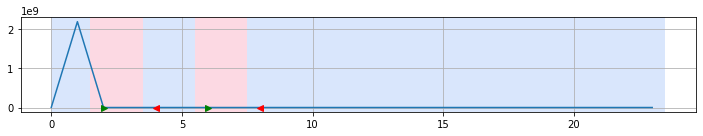

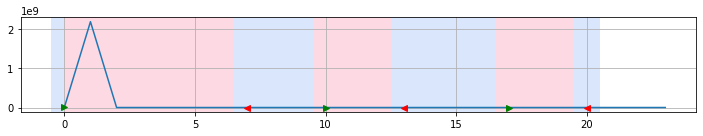

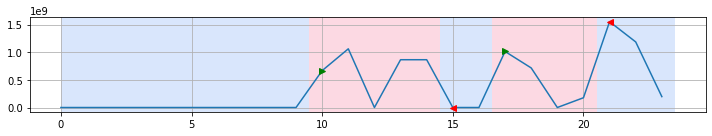

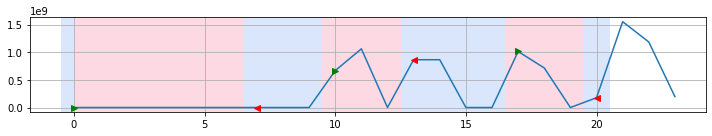

In [75]:
from utils import *
df = get_df_by_job_id(job_id = 4951)
df = df[~df.index.duplicated(keep='first')]

read_signal = df[["bytesRead"]].to_numpy()
write_signal = df[["bytesWritten"]].to_numpy()
#print(df.iloc[df.index.unique().values.tolist()])
x = df[["timestamp"]].to_numpy().flatten().tolist()
## get breakpoints from dataframe
event_serie = df["event_message"].notnull()
measured_breakpoints = event_serie[event_serie].index.unique().values.tolist()

# print(x)
# print(df.index.unique().values)
# print(measured_breakpoints)

_, read_breakpoints, _ = get_optimal_breakpoints(read_signal)
_, write_breakpoints, _ = get_optimal_breakpoints(write_signal)

#read_breakpoints.append(len(read_signal))
#write_breakpoints.append(len(write_signal))

plot_job_phases2(x, read_signal, read_breakpoints)
plot_job_phases2(x, read_signal, measured_breakpoints)
plot_job_phases2(x, write_signal, write_breakpoints)
plot_job_phases2(x, write_signal, measured_breakpoints)

# rpt.display(write_signal, measured_breakpoints, 0*write_breakpoints)
# rpt.display(read_signal, measured_breakpoints, 0*read_breakpoints)

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_namd\job_4911.csv


c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\kneed\knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


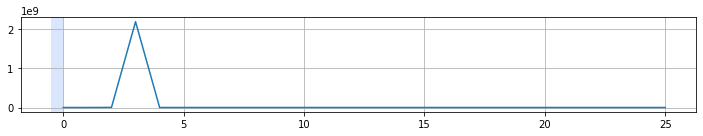

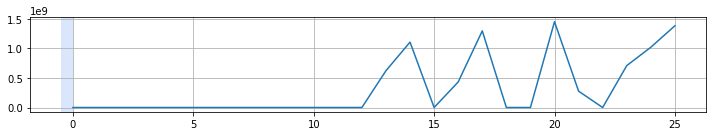

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_namd\job_4912.csv


c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\kneed\knee_locator.py:218: RuntimeWarning: invalid value encountered in true_divide
  return (a - min(a)) / (max(a) - min(a))
c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\scipy\signal\_peak_finding.py:74: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, plus)
c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\scipy\signal\_peak_finding.py:75: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, minus)
c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\scipy\signal\_peak_finding.py:74: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
c:\Users\a770398\AppData\Local\Continuum\anaconda3\envs\iosea-venv\lib\site-packages\scipy\signal\_peak_finding.py:75: RuntimeWarning: invalid value 

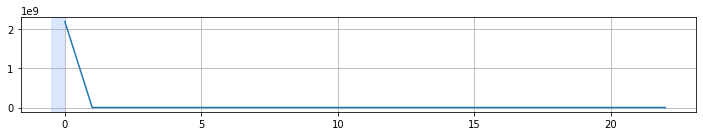

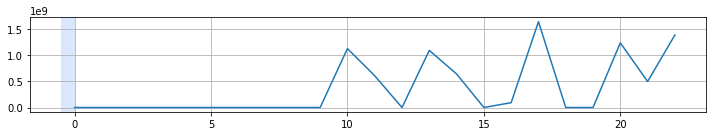

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_namd\job_4913.csv


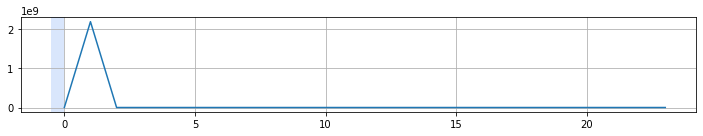

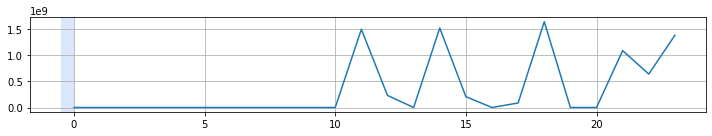

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_namd\job_4949.csv


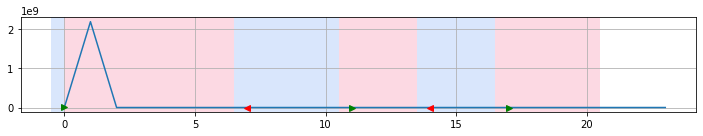

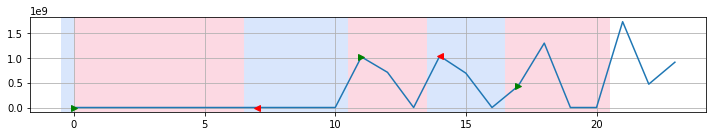

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_namd\job_4950.csv


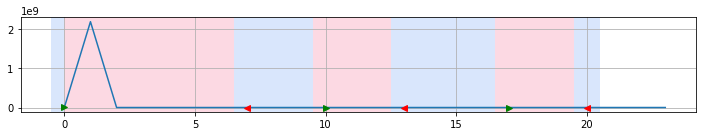

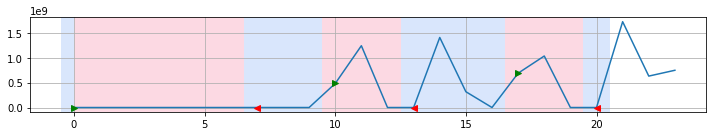

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_namd\job_4951.csv


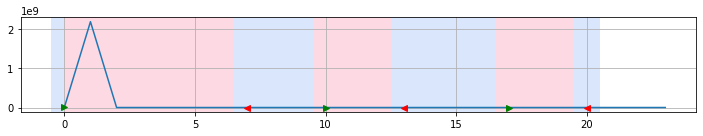

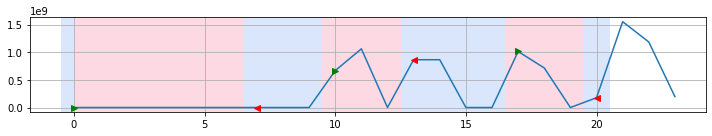

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_namd\job_4952.csv


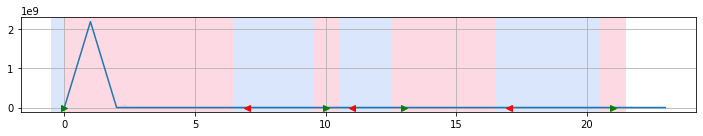

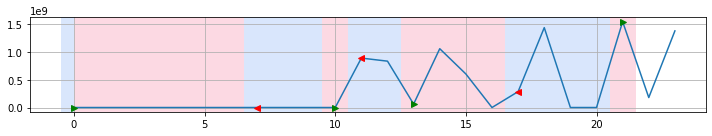

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_namd\job_4953.csv


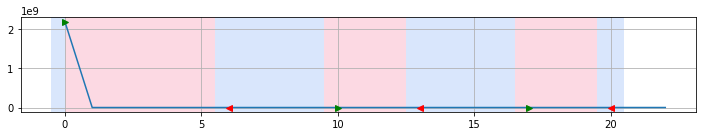

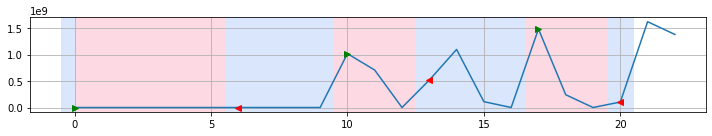

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_namd\job_4954.csv


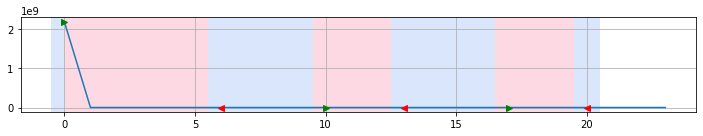

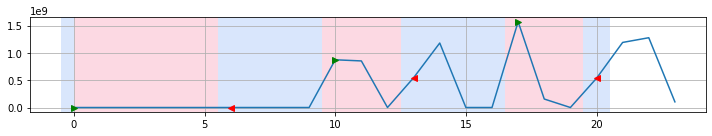

In [76]:
jobids = [4911, 4912, 4913, 4949, 4950, 4951, 4952, 4953, 4954]
for jobid in jobids:
    df = get_df_by_job_id(job_id = jobid)
    df = df[~df.index.duplicated(keep='first')]

    read_signal = df[["bytesRead"]].to_numpy()
    write_signal = df[["bytesWritten"]].to_numpy()
    #print(df.iloc[df.index.unique().values.tolist()])
    x = df[["timestamp"]].to_numpy().flatten().tolist()
    ## get breakpoints from dataframe
    event_serie = df["event_message"].notnull()
    measured_breakpoints = event_serie[event_serie].index.unique().values.tolist()

    # print(x)
    # print(df.index.unique().values)
    # print(measured_breakpoints)

    _, read_breakpoints, _ = get_optimal_breakpoints(read_signal)
    _, write_breakpoints, _ = get_optimal_breakpoints(write_signal)

    #read_breakpoints.append(len(read_signal))
    #write_breakpoints.append(len(write_signal))

    #plot_job_phases2(x, read_signal, read_breakpoints)
    plot_job_phases2(x, read_signal, measured_breakpoints)
    #plot_job_phases2(x, write_signal, write_breakpoints)
    plot_job_phases2(x, write_signal, measured_breakpoints)

#### Gysela app

retrieving C:\Users\a770398\IO-SEA\io-sea-3.4-analytics\dataset_generation\dataset_generation\dataset_gysela\job_109567.csv
len(signal) = 3242
n_bkps_max = 56
True
array_of_n_bkps = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])
costs = [1301.1352186161653, 1286.3329852854558, 1272.8512424159217, 1263.5438900602348, 1251.018491055685, 1238.6284325815484, 1226.1030335769985, 1214.6891170631518, 1202.163718058602, 1190.728944643597, 1179.214453077646, 1166.7896291252005, 1156.084473461423, 1144.1030547744283, 1134.0997794725718, 1122.4782506593567, 1112.7761418072273, 1101.7522448230116, 1092.0501359708824, 1081.4435759911544, 1071.7414671390252, 1062.2330579681693, 1052.795257738246, 1043.2868485673898, 1034.0610893796859, 1024.55268020883, 1015.2862264301045, 1005.7778172592485, 996.

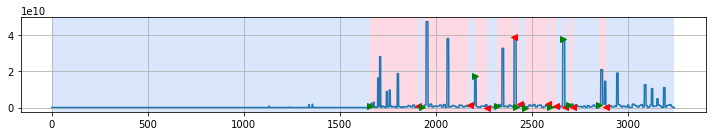

In [256]:
import ruptures as rpt
from kneed import KneeLocator

# two jobids : 108010, 109567

df = get_df_by_job_id(job_id=109567)
signal = (df[["bytesWritten"]]).to_numpy()
x = df[["timestamp"]].to_numpy().tolist()
# generate signal
print(f"{len(signal) = }")
algo = rpt.KernelCPD(kernel="rbf", min_size=1).fit(signal)
n_bkps_max = int((np.sqrt(len(signal))))
print(f"{n_bkps_max = }")
# check sanity
print(rpt.utils.sanity_check(len(signal), n_bkps_max, 1, 1))

# segment
_ = algo.predict(n_bkps_max)


array_of_n_bkps = np.arange(1, n_bkps_max + 1)

def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

costs = [np.abs(get_sum_of_cost(algo=algo, n_bkps=n_bkps)) for n_bkps in array_of_n_bkps]
print(f"{array_of_n_bkps = }")
print(f"{costs = }")
elbow = KneeLocator(array_of_n_bkps, costs, S= 1,
                         curve="convex",  direction="decreasing").elbow

optimal_n_breakpoints = elbow if elbow else n_bkps_max

print(f"{optimal_n_breakpoints = }")
print(f"{costs = }")
optimal_breakpoints = algo.predict(n_bkps=optimal_n_breakpoints)
optimal_cost = costs[array_of_n_bkps.tolist().index(optimal_n_breakpoints)]
print(f"{optimal_cost = }")
plot_job_phases2(x, signal, optimal_breakpoints)